#**PROBLEMA DE NEGOCIO**


---




La urgencia por detectar fraudes en transacciones móviles de dinero ha llevado a una empresa del segmento Fintech a buscar soluciones innovadoras. Como científicos de datos hemos sido convocados para desarrollar un modelo de machine learning que pueda distinguir de manera precisa entre transacciones legítimas y fraudulentas, estableciendo así un estándar de seguridad en el sector financiero móvil global.

### **Tus tareas principales serán:**

**1. Preprocesamiento de Datos:** Realizar limpieza de datos, manejar valores faltantes, codificación de variables categóricas y normalización/escalado de datos.

**2. Exploración de Datos:** Analizar y comprender el conjunto de datos proporcionado, identificar variables llaves y realizar visualizaciones para entender las relaciones entre las variables y seleccionar las características relevantes.

**3. Construcción de Modelos:** Experimentar con algunos algoritmos de machine learning como Regresión Logística, Árboles de Decisión, Random Forest, Naive Bayes, entre otros.

**4. Evaluación y Selección del Modelo:** Evaluar los modelos utilizando métricas como precisión, recall, área bajo la curva ROC, y F1-score. Seleccionar el modelo con el mejor rendimiento para la detección de transacciones bancarias fraudulentas.

#**1. Configuración del Ambiente**


---




In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.ticker as ticker
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTETomek
global df_banco, resultados

c:\Users\Mario Arellano\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#**2. Preprocesamiento de Datos**


---


In [2]:
df_banco = pd.read_csv('C:/Users/Mario Arellano/Downloads/Proyecto/PS_20174392719_1491204439457_log.csv')
df_banco.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
def procesar_datos():
  global df_banco
  
  # Vamos a realizar el tratamiento de los datos nulos
  # Primero verifiquemos si hay nulos.
  
  nulos = df_banco.isna().sum()
  if nulos.any():
    df_banco = df_banco.dropna()
  else:
    df_banco = df_banco
    
  # Ahora vamos a verificar duplicados y darle los tra-
  # tamientos adecuados.
  
  duplicados = df_banco.duplicated().sum()
  if duplicados > 0:
    df_banco = df_banco.drop_duplicates()
  else:
    df_banco = df_banco
    
  # Vamos a crear una nueva columna type2, para esto usaremos la función str, que
  # creara un nuevo objeto string partiendo de otro, en este caso con str[0] con
  # el 0 estamos seleccionando la letra incial de cada elemento de la columna nameOrig
  # tambien de la columna name Dest y concatenamos este string, dandonos como resultado
  # un nuevo objeto string que es la combinación de ambas inciales.
  
  df_banco["type2"] = df_banco["nameOrig"].str[0] + df_banco["nameDest"].str[0]

  ## Agregando nuevas variables
  
  # Vamos a convertir nuestras variables en día y horas. Cada step
  # hace referencia a 1 hora del mes. Tenemos 743 y si dividimos
  # en clases 24 step cada 1, tendríamos los días.
  
  intervalos_horas = [0, 24, 48,
                      72, 96, 120,
                      144, 168, 192,
                      216, 240, 264,
                      288, 312, 336,
                      360, 384, 408,
                      432, 456, 480,
                      504, 528, 552,
                      576, 600, 624,
                      648, 672, 696,
                      720, 744]
  
  etiquetas_dia = [1, 2, 3,
                  4, 5, 6,
                  7, 8, 9,
                  10, 11, 12,
                  13, 14, 15,
                  16, 17, 18,
                  19, 20, 21,
                  22, 23, 24,
                  25, 26, 27,
                  28, 29, 30,
                  31]
  
  df_banco["día"] = pd.cut(x = df_banco["step"], bins = intervalos_horas, labels = etiquetas_dia)
  
  # Creando una nueva variable llamada momento del día
  
  df_banco["momento_dia"] = (pd.cut(
      ((df_banco["step"] - 1) % 24) + 1,
      bins=[0, 6, 12, 18, 24],
      labels=["madrugada", "mañana", "tarde", "noche"],
      ordered=False).astype("object"))
  
  # Creando la variable día de la semana
  
  df_banco["dia_semana"] = df_banco["día"].apply(lambda x: 'lunes' if x % 7 == 1
                                                  else 'martes' if x % 7 == 2
                                                  else 'miércoles' if x % 7 == 3
                                                  else 'jueves' if x % 7 == 4
                                                  else 'viernes' if x % 7 == 5
                                                  else 'sábado' if x % 7 == 6
                                                  else 'domingo')
  
  columnas_a_tratar = ["type","type2","momento_dia"]
  
  # Ahora vamos a empezar a realizar el tratamiento per-
  # tinente para las columnas tipo categorícas, ya que
  # para trabajar con modelos de machine learning es
  # necesario que esten numéricos.
  
  
  # Vamos a proceder a realizar un codificación OneHot usando el método
  # .get_dummies y usaremos el atributo drop_first = True, con el fin de
  # que se elimine la primera columna y de esta manera evitemos que se
  # genere un problema de multicolinealidad.
  
  df_banco = pd.get_dummies(df_banco, columns = columnas_a_tratar, drop_first = True, dtype = int)
  
  # Vamos a proceder a eliminar las columnas que no nos son necesarias.
  # Primero vamos a crear una varaible con una lista de columnas, las
  # cuales queremos eliminar.
  
  columnas_a_eliminar = ["nameOrig", "nameDest", "isFlaggedFraud", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
  
  # Ahora procederemos a eliminar las columnas.
  
  df_banco = df_banco.drop(columnas_a_eliminar,axis=1)

  # Creando la columna hora del día
  
  df_banco["hora_del_dia"] = df_banco["step"].apply(lambda x: x % 24 if x % 24 != 0 else 24)

  return df_banco

In [5]:
procesar_datos()
df_banco.head()

,step,amount,isFraud,día,dia_semana,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CM,momento_dia_mañana,momento_dia_noche,momento_dia_tarde,hora_del_dia
0,1,9839.64,0,1,lunes,0,0,1,0,1,0,0,0,1
1,1,1864.28,0,1,lunes,0,0,1,0,1,0,0,0,1
2,1,181.00,1,1,lunes,0,0,0,1,0,0,0,0,1
3,1,181.00,1,1,lunes,1,0,0,0,0,0,0,0,1
4,1,11668.14,0,1,lunes,0,0,1,0,1,0,0,0,1


#**3. Exploración de Datos**


---


## Explorando nuestras variables

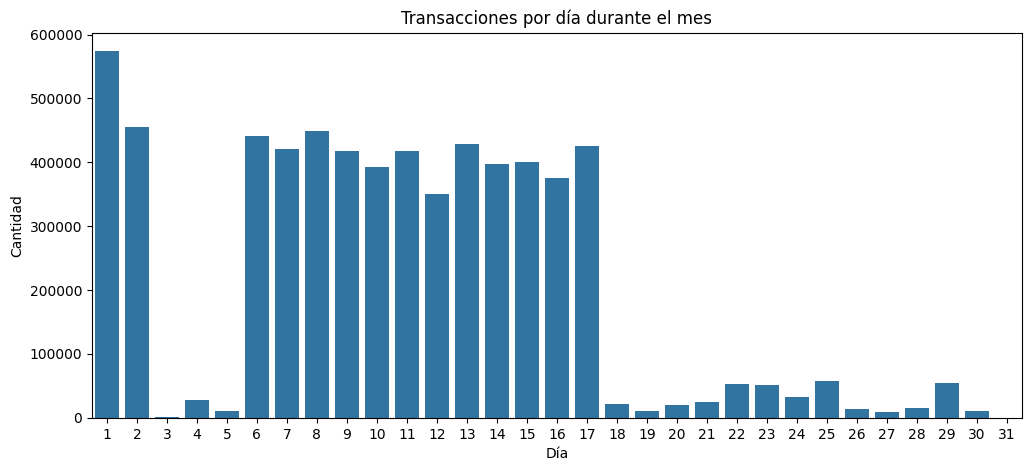

In [6]:
def grafico_transaccion_mes():
    # Exploremos nuestras variables.
    fig, axs = plt.subplots(figsize=(12, 5))
    # Gráfico 1 Gráfico barras para nuestra variable step(Hace referencia al tiempo)
    sns.countplot(x="día", data=df_banco)
    axs.set_title("Transacciones por día durante el mes")
    axs.set_ylabel("Cantidad")
    axs.set_xlabel("Día")
grafico_transaccion_mes()

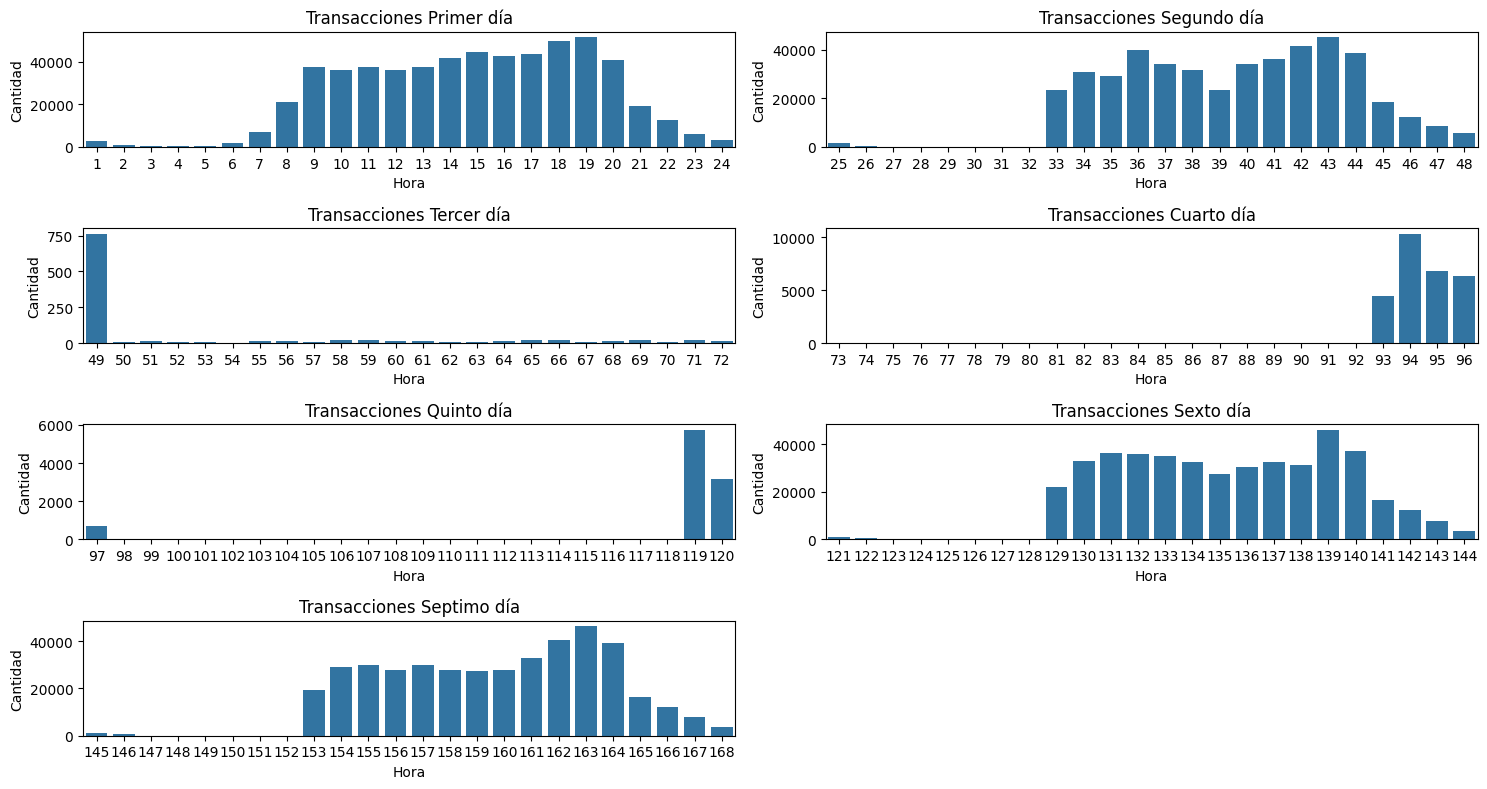

In [7]:
## Primero vamos analizar el comportamiento de las transacciones por hora,
## los primeros 4 días por separado

df_banco_día_1 = df_banco[(df_banco["step"] >= 0) & (df_banco["step"] <= 24)]
df_banco_día_2 = df_banco[(df_banco["step"] > 24) & (df_banco["step"] <= 48)]
df_banco_día_3 = df_banco[(df_banco["step"] > 48) & (df_banco["step"] <= 72)]
df_banco_día_4 = df_banco[(df_banco["step"] > 72) & (df_banco["step"] <= 96)]
df_banco_día_5 = df_banco[(df_banco["step"] > 96) & (df_banco["step"] <= 120)]
df_banco_día_6 = df_banco[(df_banco["step"] > 120) & (df_banco["step"] <= 144)]
df_banco_día_7 = df_banco[(df_banco["step"] > 144) & (df_banco["step"] <= 168)]

# Cantidad de transacción por día.

df_banco_agrupacion = df_banco.loc[:,["step","día"]]
df_banco_agrupacion.groupby("step")["día"].count()

def grafico_transacciones_dia():
    
    fig, axs = plt.subplots(4, 2 , figsize=(15, 8))

    # Gráfico 1
    sns.countplot(x="step", ax = axs[0,0], data=df_banco_día_1)
    axs[0,0].set_title("Transacciones Primer día")
    axs[0,0].set_ylabel("Cantidad")
    axs[0,0].set_xlabel("Hora")

    # Gráfico 2
    sns.countplot(x="step", ax = axs[0,1], data=df_banco_día_2)
    axs[0,1].set_title("Transacciones Segundo día")
    axs[0,1].set_ylabel("Cantidad")
    axs[0,1].set_xlabel("Hora")

    # Gráfico 3
    sns.countplot(x="step", ax = axs[1,0], data=df_banco_día_3)
    axs[1,0].set_title("Transacciones Tercer día")
    axs[1,0].set_ylabel("Cantidad")
    axs[1,0].set_xlabel("Hora")

    # Gráfico 4
    sns.countplot(x="step", ax = axs[1,1], data=df_banco_día_4)
    axs[1,1].set_title("Transacciones Cuarto día")
    axs[1,1].set_ylabel("Cantidad")
    axs[1,1].set_xlabel("Hora")

    # Gráfico 5
    sns.countplot(x="step", ax = axs[2,0], data=df_banco_día_5)
    axs[2,0].set_title("Transacciones Quinto día")
    axs[2,0].set_ylabel("Cantidad")
    axs[2,0].set_xlabel("Hora")

    # Gráfico 6
    sns.countplot(x="step", ax = axs[2,1], data=df_banco_día_6)
    axs[2,1].set_title("Transacciones Sexto día")
    axs[2,1].set_ylabel("Cantidad")
    axs[2,1].set_xlabel("Hora")

    # Gráfico 7
    sns.countplot(x="step", ax = axs[3,0], data=df_banco_día_7)
    axs[3,0].set_title("Transacciones Septimo día")
    axs[3,0].set_ylabel("Cantidad")
    axs[3,0].set_xlabel("Hora")

    # Eliminamos el ultimo eje que usarmos
    fig.delaxes(axs[3,1])

    # Ajustamos el espacio entre los gráficos
    plt.subplots_adjust(hspace = 0.5)
    plt.tight_layout()
    plt.show()
    
grafico_transacciones_dia()

<p align ="justify">Podemos observar el comportamiento de las transacciónes el primer día, esto con el fin de ver más o menos como se comportan los datos.</p>

<p align ="justify">Se destaca que las primeras horas del día las transacciones realizadas son bajas por debajo de las 10mil transacciones, esto puede ser debido a que si tomamos en cuenta que la primera hora del día comienza  a las 0:00am, es decir es de madrugada.</p>

<p align ="justify">Partiendo de esto podemos observar que, las personas en mayor medida, empiezan a realizar sus labores díarias apartir de las 6 o 7 am que salen de sus casas a laborar o hacer las diligencias que requieran durante el día, por tanto es normal que se vean cantidades mayores de transacciones a partir de estas horas.</p>

<p align ="justify">Ahora cabe destacar que aunque el aumento no es paulatino, vemos que el pico de las transacciones lo encontramos en las horas 18 y 19 del día, es decir 6 o 7 de la tarde, lo que indica que esto puede deberser a que suele ser las horas despues de que las personas libren de sus trabajos es decir ya finalizaron sus horarios laborarios, no todos estan libres de trabajo a esta hora, pero si la mayoría.</p>

<p align ="justify">Podemos verificar esto observando el comportamiento en 4 de los 7 primeros días. Las transacciones a primeras horas son bajas y van en aumento y presentan un pico a las 6 y 7 de la tarde/noche. Luego van disminuyendo bastante las ultimas 3 horas del día, como observamos en el primer, segundo, sexto y septimo día. En los días restantes observamos pocos niveles de transacciones pero las transacciones sobre todo en las ultimas 3 horas durante esos días se mantienen muy similares con el resto de los días.</p>

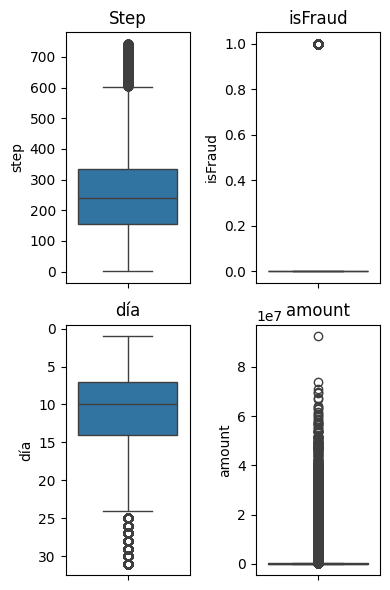

In [8]:
def graficos_boxplot():

    fig, axs = plt.subplots(2, 2, figsize=(4,6))

    sns.boxplot(data = df_banco["step"], ax = axs[0,0])
    axs[0,0].set_title("Step")
    sns.boxplot(data = df_banco["isFraud"], ax = axs[0,1])
    axs[0,1].set_title("isFraud")
    sns.boxplot(data = df_banco["día"], ax = axs[1,0])
    axs[1,0].set_title("día")
    sns.boxplot(data = df_banco["amount"], ax = axs[1,1])
    axs[1,1].set_title("amount")

    # Ajustamos el espacio entre los gráficos
    plt.subplots_adjust(hspace = 0.5)
    plt.tight_layout()
    plt.show()
    
graficos_boxplot()

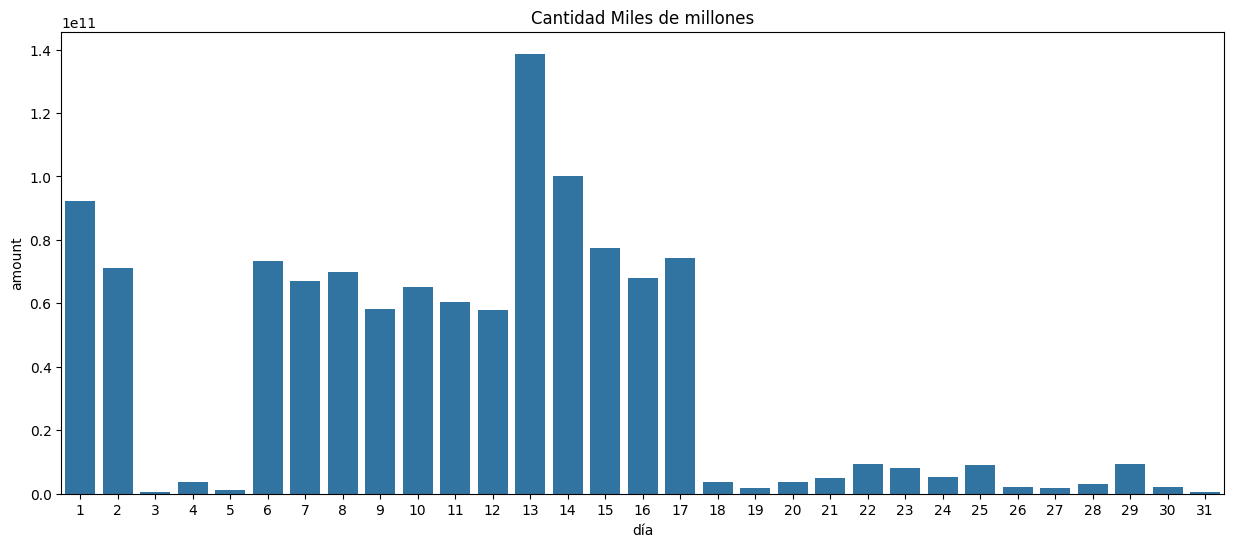

In [9]:
# Creando variables con el fin de poder obtener las cantidades en miles para nuestro grafico
def grafico_cantidad_dia():
    
    df_banco_monto = df_banco
    df_banco_monto["amount"] = df_banco_monto["amount"].round().astype(int)
    cantidad_por_dia = df_banco_monto[["día","amount"]]
    monto_total_dia = cantidad_por_dia.groupby("día")["amount"].sum().reset_index()

    # Cantidad monto transferido por día.
    #cantidad_transferida =

    fig, axs = plt.subplots(figsize=(15,6))

    sns.barplot(x = "día", y = "amount", data = monto_total_dia)
    axs.set_title("Cantidad Miles de millones")
    
grafico_cantidad_dia()

[Text(0, 0, 'Buenas transacciones'), Text(1, 0, 'Transacciones Fraudulentas')]

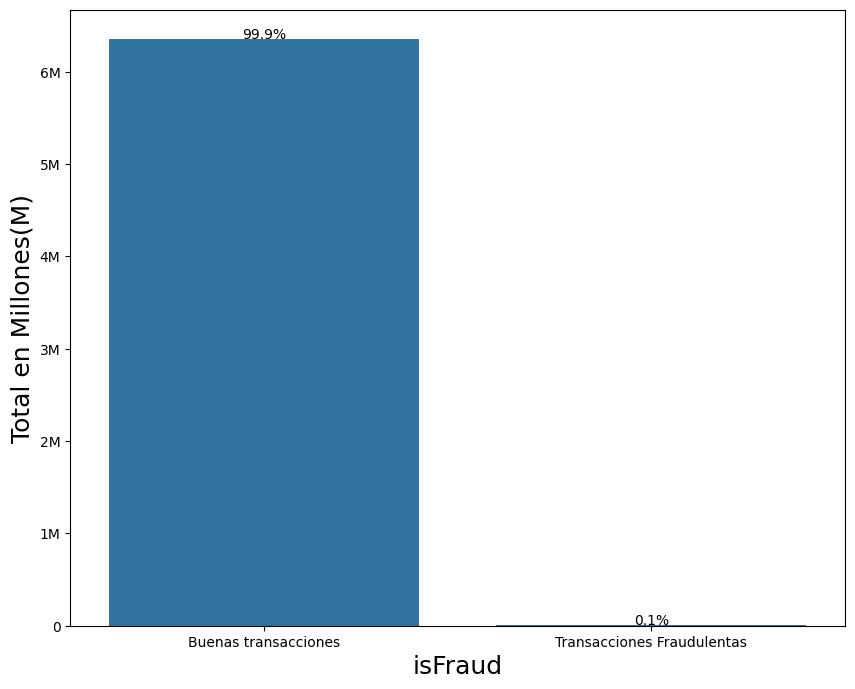

In [26]:
# Veamos como esta la variable a estudiar
fig, axs = plt.subplots(figsize=(10, 8))
sns.countplot(x="isFraud", data=df_banco)
# Agregar porcentajes encima de las barras
total_transacciones = len(df_banco)
for p in axs.patches:
    height = p.get_height()
    axs.text(p.get_x() + p.get_width() / 2, height + 0.1, f"{height/total_transacciones:.1%}", ha="center")
axs.set_xlabel("isFraud", fontsize=18)
axs.set_ylabel("Total en Millones(M)", fontsize=18)
axs.set_yticklabels(["0","1M","2M","3M","4M","5M", "6M"])
axs.set_xticklabels(["Buenas transacciones","Transacciones Fraudulentas"])


Finalizando con nuestro análisis de las varaibles, vamos a proceder con el eliminado de las variables que no usaremos para el modelo.

In [11]:
df_banco = df_banco.drop(["step", "dia_semana"],axis=1)

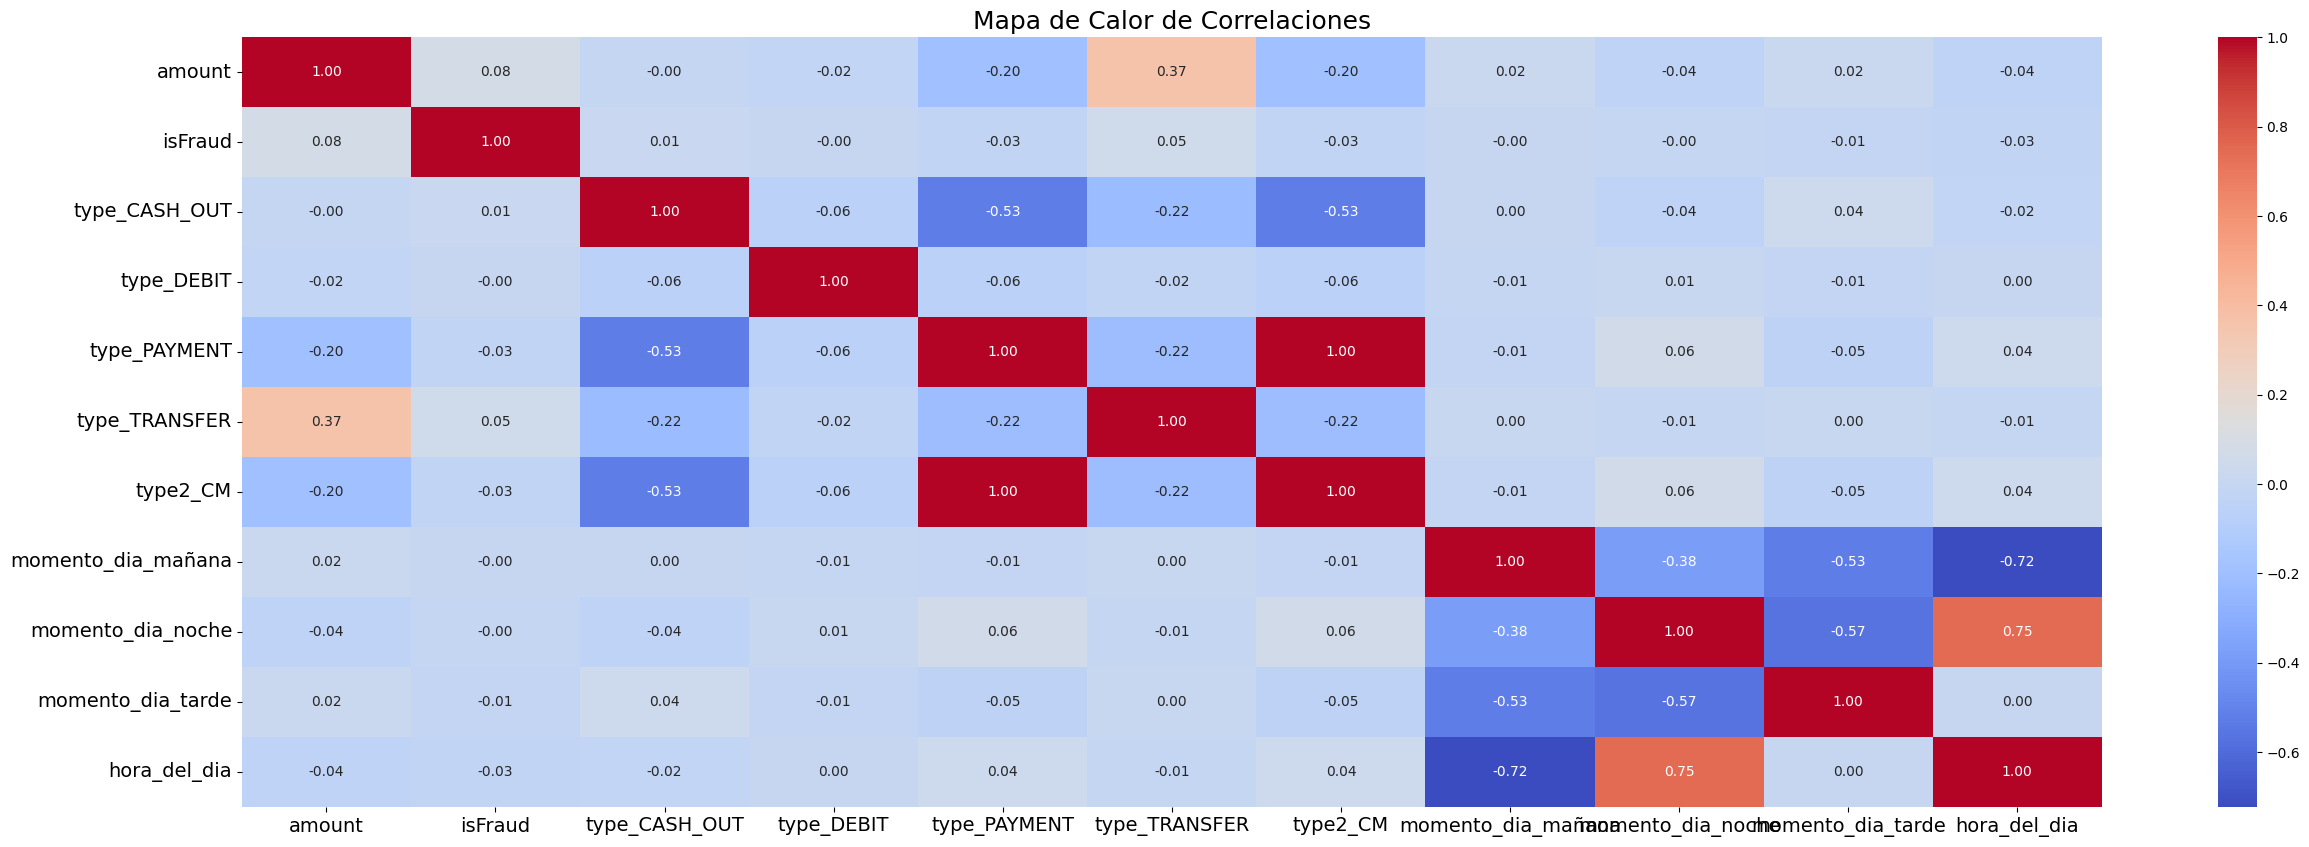

In [12]:
plt.figure(figsize=(30, 10))
heatmap = sns.heatmap(df_banco.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=18)
plt.show()

 Balanceando directamente la variable isFraud pero luego de haber separado nuestra data en train_x y train_y, esto para evitar el data leakge. El data leakge es una fuga de de datos que se da debido a que estamos pasando información de nuestros datos de prueba a nuestro modelo para entrenarlo, lo que genera un resultado engañoso a la hora de obtener las métricas de que el modelo es perfecto, pero al entrar nuevos datos al modelo, las métricas se van en picada.

In [13]:
# Primero vamos a separar la base de datos de entrenamiento(train)
# y la de pruebas(test)
y = df_banco["isFraud"]
x = df_banco.drop(columns="isFraud")
# Vamos a declarar las variables trainx, test_x, train_y y test_y
# y estas almacenaran los datos que usaremos y separando con
# train_test_split los datos que usaremos tanto para pruebas como
# para entrenamiento de nuestra variable dependiente(respuestas) y
# nuestras variables independientes(predictoras)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.30, random_state = 77)

# Inicializamos la biblioteca, con la semilla random_state=77, al probar nuestro modelo usando está misma semilla, podra
# generar los mismos datos/resultados que generamos.
smk = SMOTETomek(random_state=42)
# Aplicamos el método fit_resample() resample significa recrea o genera sinteticamente nuevos datos en train_x y train_y de manera que quede proporcionalmente
# correcta. Ahora ya deberían de estar igualmente proporcionales.
# NOTA: Para poder realizar esto, primero tenemos que separar las variables como hicimos arriba.
train_x, train_y = smk.fit_resample(train_x, train_y)
# Ahora concatenamos, unimos todas nuestras variables en el mismo dataframe, para ahora tener nuestro dataframe listo para realizar nuestros
# modelos de machine learning
df_banco_train = pd.concat([train_x, train_y], axis=1)

In [14]:
df_banco_train["isFraud"].value_counts()

isFraud
0    4419080
1    4419080
Name: count, dtype: int64

Text(0, 0.5, 'Total')

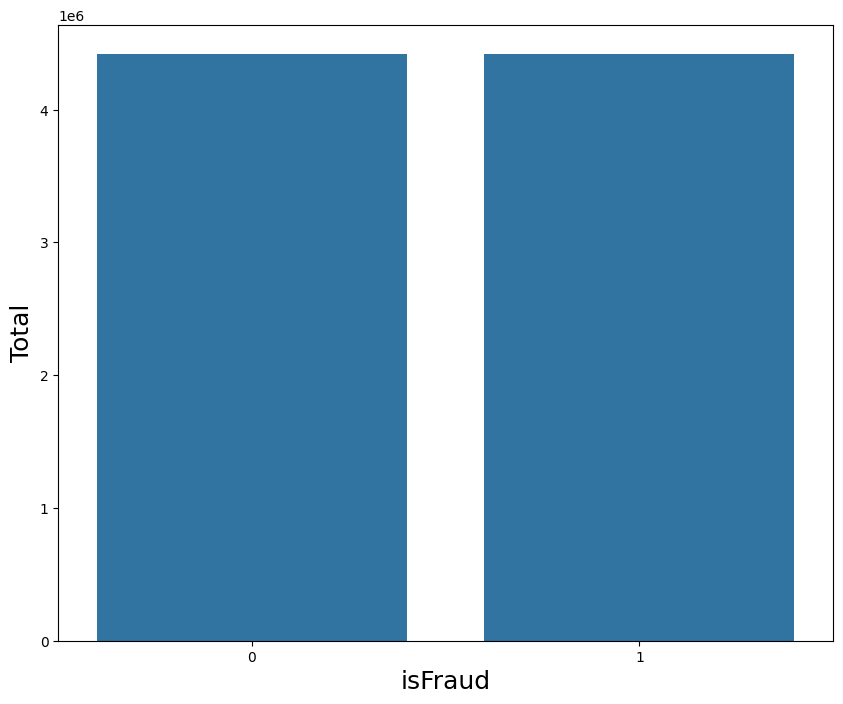

In [15]:
# Veamos como quedo la variable isFraud balanceada
fig, axs = plt.subplots(figsize=(10, 8))
sns.countplot(x="isFraud", data=df_banco_train)
axs.set_xlabel("isFraud", fontsize=18)
axs.set_ylabel("Total", fontsize=18)

In [16]:
df_banco

,amount,isFraud,día,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CM,momento_dia_mañana,momento_dia_noche,momento_dia_tarde,hora_del_dia
0,9840,0,1,0,0,1,0,1,0,0,0,1
1,1864,0,1,0,0,1,0,1,0,0,0,1
2,181,1,1,0,0,0,1,0,0,0,0,1
3,181,1,1,1,0,0,0,0,0,0,0,1
4,11668,0,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682,1,31,1,0,0,0,0,0,1,0,23
6362616,6311409,1,31,0,0,0,1,0,0,1,0,23
6362617,6311409,1,31,1,0,0,0,0,0,1,0,23
6362618,850003,1,31,0,0,0,1,0,0,1,0,23


#**4. Construcción de Modelos**


---


In [17]:
#@title
def crea_modelos():
  global df_banco, resultados, test_y, predictions_LR, predictions_dt, predictions_RF,  predictions_NBG, model, train_x, test_x, train_y, test_y

  # Ahora vamos a proceder a crear y entrenar los modelos

  # MODELO 1: REGRESIÓN LOGISTICA
  # Primero crearemos la variable model_LR donde se inicializará el modelo
  model_LR =  LogisticRegression()
  # Ahora entrenaremos el modelo usando el método .fit y los datos de entra
  # namiento de x y y.
  model_LR.fit(train_x,train_y)
  # Ahora vamos a correr el modelo con los datos de prueba de x
  predictions_LR = model_LR.predict(test_x)

  # Obteniendo las métricas de nuestro modelo, para esto usaremos nuestros
  # datos de prueba de la variable a predecir que es y la predicción que
  # que realizamos al ejecutar el modelo en los datos de prueba, la cual
  # se guardo en la variable predictions_modelo(Logistic regression)

  # ACCURACY, PREICISION, RECALL, F1 AND AUC ROC
  accuracy_logistic_regression = accuracy_score(test_y,predictions_LR)
  precision_logistic_regression = precision_score(test_y,predictions_LR)
  recall_logistic_regression = recall_score(test_y,predictions_LR)
  f1_logistic_regression = f1_score(test_y,predictions_LR)
  auc_roc_logistic_regression = roc_auc_score(test_y,predictions_LR)

  # MODELO 2: DEICISION TREE (ARBOLES DE DECISIONES)
  # Primero crearemos la variable model_dt donde se inicializará el modelo
  # donde usaremos el criterio de la entroía para generar nuestro modelo
  model_dt = DecisionTreeClassifier(criterion = "entropy",
                                    splitter = "best",
                                    random_state = 42,
                                    max_depth = 8
                                    )
  # Ahora entrenaremos el modelo usando el método .fit y los datos de entra
  # namiento de x y y.
  model_dt.fit(train_x, train_y)
  # Ahora vamos a correr el modelo con los datos de prueba de x
  predictions_dt = model_dt.predict(test_x)

  # Obteniendo las métricas de nuestro modelo, para esto usaremos nuestros
  # datos de prueba de la variable a predecir que es y la predicción que
  # que realizamos al ejecutar el modelo en los datos de prueba, la cual
  # se guardo en la variable predictions_modelo(DEICISION TREE)

  # ACCURACY, PREICISION, RECALL, F1 AND AUC ROC
  accuracy_decision_tree = accuracy_score(test_y,predictions_dt)
  precision_decision_tree = precision_score(test_y,predictions_dt)
  recall_decision_tree = recall_score(test_y,predictions_dt)
  f1_decision_tree = f1_score(test_y,predictions_dt)
  auc_roc_decision_tree = roc_auc_score(test_y,predictions_dt)

  # MODELO 3: RANDOM FOREST (BOSQUE ALEATORIO)
  # Primero crearemos la variable model_dt donde se inicializará el modelo
  # donde usaremos el atributo de max_depth para indicar la profundidad hasta
  # donde queremos llegar, n_estimators es el n° de arboles y por ultimo usamos
  # el criterio de gini para este caso.
  model_RF = RandomForestClassifier(n_estimators = 18,
                                    criterion = "gini", 
                                    random_state = 42,
                                    max_depth = 8,
                                    bootstrap = True,
                                    max_samples = 0.75
                                    )
  # Ahora entrenaremos el modelo usando el método .fit y los datos de entra
  # namiento de x y y.
  model_RF.fit(train_x, train_y)
  # Ahora vamos a correr el modelo con los datos de prueba de x
  predictions_RF  = model_RF.predict(test_x)

  # Obteniendo las métricas de nuestro modelo, para esto usaremos nuestros
  # datos de prueba de la variable a predecir que es y la predicción que
  # que realizamos al ejecutar el modelo en los datos de prueba, la cual
  # se guardo en la variable predictions_modelo(DEICISION TREE)

  # ACCURACY, PREICISION, RECALL, F1 AND AUC ROC
  accuracy_Random_Forest = accuracy_score(test_y,predictions_RF)
  precision_Random_Forest = precision_score(test_y,predictions_RF)
  recall_Random_Forest = recall_score(test_y,predictions_RF)
  f1_Random_Forest = f1_score(test_y,predictions_RF)
  auc_roc_Random_Forest = roc_auc_score(test_y,predictions_RF)

  # MODELO 4 NAIVE BAYES GAUSSIANO
  # Primero crearemos la variable model_dt donde se inicializará el modelo
  model_NBG  = GaussianNB()
  # Ahora entrenaremos el modelo usando el método .fit y los datos de entra
  # namiento de x y y.
  model_NBG.fit(train_x, train_y)
  # Ahora vamos a correr el modelo con los datos de prueba de x
  predictions_NBG = model_NBG.predict(test_x)

  # Obteniendo las métricas de nuestro modelo, para esto usaremos nuestros
  # datos de prueba de la variable a predecir que es y la predicción que
  # que realizamos al ejecutar el modelo en los datos de prueba, la cual
  # se guardo en la variable predictions_modelo(DEICISION TREE)

  # ACCURACY, PREICISION, RECALL, F1 AND AUC ROC
  accuracy_naive_bayes_g = accuracy_score(test_y,predictions_NBG)
  precision_naive_bayes_g = precision_score(test_y,predictions_NBG)
  recall_naive_bayes_g = recall_score(test_y,predictions_NBG)
  f1_naive_bayes_g = f1_score(test_y,predictions_NBG)
  auc_roc_naive_bayes_g = roc_auc_score(test_y,predictions_NBG)

  #Creamos una lista con los nombres de los modelos usados.
  nombre_modelo=['Regresión Logística','Árbol de decisiones','Random Forest','Naive Bayes Gaussiano']

  # LLenamos las listas con los resultados obtenidos de cada modelo en el paso anterior
  # y usaremos extend() para agregar varios elementos a una lista,en este caso, llenaremos
  # las listas usandos las métricas que calculamos.

  accuracy = []
  accuracy.extend([accuracy_logistic_regression,
                   accuracy_decision_tree,
                   accuracy_Random_Forest,
                   accuracy_naive_bayes_g])

  precision = [precision_logistic_regression,
               precision_decision_tree,
               precision_Random_Forest,
               precision_naive_bayes_g]

  recall = []
  recall.extend([recall_logistic_regression,
                 recall_decision_tree,
                 recall_Random_Forest,
                 recall_naive_bayes_g] )

  f1_scores= []
  f1_scores.extend([f1_logistic_regression,
                    f1_decision_tree,
                    f1_Random_Forest,
                    f1_naive_bayes_g])

  auc_roc = []
  auc_roc.extend([auc_roc_logistic_regression,
                  auc_roc_decision_tree,
                  auc_roc_Random_Forest,
                  auc_roc_naive_bayes_g])

  #Creamos nuestro diccionario de Resutados

  resultados = {
    'Model': nombre_modelo,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1_scores,
    'AUC-ROC': auc_roc
  }

In [18]:
crea_modelos()

#Matríz de confusión
print(confusion_matrix(test_y, predictions_LR))
print(confusion_matrix(test_y, predictions_dt))
print(confusion_matrix(test_y, predictions_RF))
print(confusion_matrix(test_y, predictions_NBG))

for i, model in enumerate(resultados['Model']):
    print(f"Modelo: {model}")
    print(f"Accuracy: {resultados['Accuracy'][i]}")
    print(f"Precisión: {resultados['Precision'][i]}")
    print(f"Recall: {resultados['Recall'][i]}")
    print(f"F1-score: {resultados['F1-score'][i]}")
    print(f"AUC-ROC: {resultados['AUC-ROC'][i]}\n")

[[1631918  274369]
 [    727    1772]]
[[1851680   54607]
 [    880    1619]]
[[1849782   56505]
 [    780    1719]]
[[1874301   31986]
 [   1751     748]]
Modelo: Regresión Logística
Accuracy: 0.8558790770678326
Precisión: 0.006417011599146812
Recall: 0.7090836334533813
F1-score: 0.012718920470858455
AUC-ROC: 0.7825775741965786

Modelo: Árbol de decisiones
Accuracy: 0.9709307381759925
Precisión: 0.028794507878917228
Recall: 0.647859143657463
F1-score: 0.05513835674755215
AUC-ROC: 0.8096067022922976

Modelo: Random Forest
Accuracy: 0.9699887782077194
Precisión: 0.029523907666941466
Recall: 0.687875150060024
F1-score: 0.056617756039721356
AUC-ROC: 0.8291168790907332

Modelo: Naive Bayes Gaussiano
Accuracy: 0.9823254152115534
Precisión: 0.0228508584346551
Recall: 0.29931972789115646
F1-score: 0.0424601935685295
AUC-ROC: 0.641270256294684



#**5. Evaluación y Selección del Modelo**


---


In [19]:
#@title
def visualiza_resultados():
  global df_banco, resultados
  results_df = pd.DataFrame(resultados)
  results_df.set_index('Model', inplace=True)
  results_df = results_df.T
  colors = ['#0077b6', '#CDDBF3','#9370DB', '#DDA0DD']
  results_df.plot(kind='bar', figsize=(12, 6), colormap='viridis', rot=0, color=colors)
  plt.title('Comparación de Métricas por Modelo')
  plt.xlabel('Métricas')
  plt.ylabel('Puntuación')
  plt.legend(title='Modelos')
  plt.tight_layout()
  plt.show()

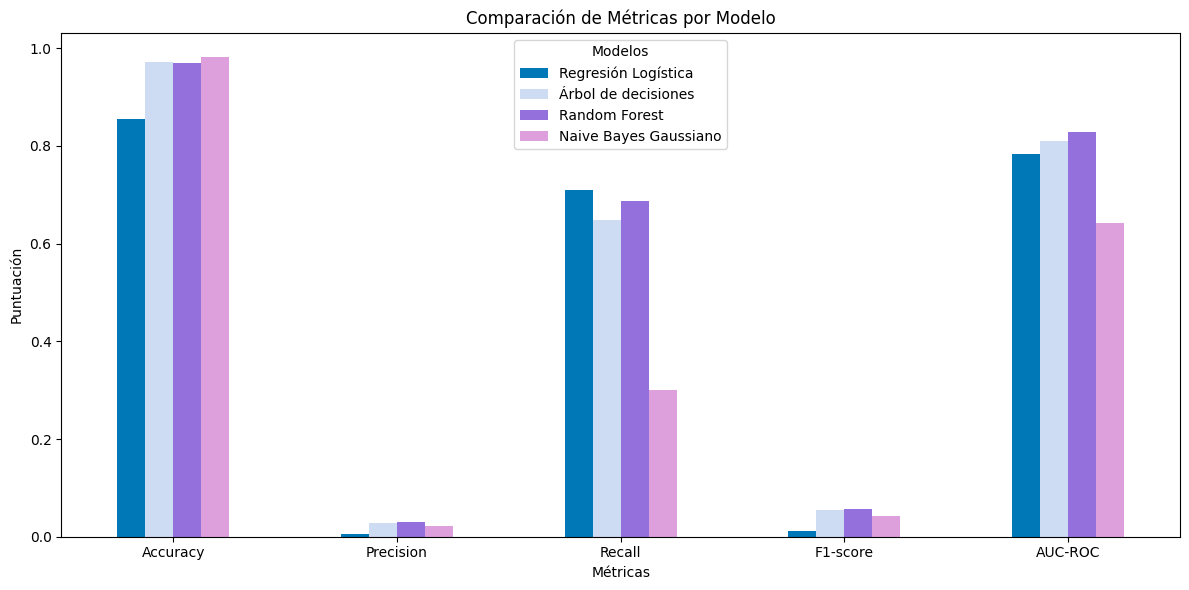

In [20]:
visualiza_resultados()